<a href="https://colab.research.google.com/github/franciscogonzalez-gal/statistical-learning-2/blob/main/Tarea_2_Statistical_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2 - Statistical Learning 2

**Nombre:** Francisco González

**Carnet:** 24002914

# Parte 1 - Investigación Teórica

## 1. Forecasting con RNN (RNN Simple)

### a. Funcionalidad principal
Las Redes Neuronales Recurrentes (RNN) están diseñadas para manejar datos secuenciales, lo que las hace ideales para forecasting de series de tiempo. Su principal característica es la existencia de conexiones recurrentes que permiten que la información fluya de un paso temporal al siguiente, manteniendo un “estado oculto” que resume la información relevante de la secuencia previa.  
A diferencia de un modelo lineal tradicional o de una red feedforward, una RNN procesa la información paso a paso, reutilizando su estado interno como memoria, lo que le permite capturar dependencias temporales y patrones dinámicos en los datos. Esto la hace más flexible que los modelos que asumen independencia entre observaciones.

### b. Ventajas claves
- Capacidad de modelar dependencias temporales y patrones no lineales.
- Flexibilidad para manejar secuencias de distinta longitud.
- Adecuada para datos con correlaciones temporales complejas que no son capturadas por métodos estadísticos clásicos.

### c. Limitaciones
Las RNN simples sufren del problema de **memoria de corto plazo**, ya que su capacidad para retener información se degrada rápidamente con el tiempo.  
Esto se debe en parte al **desvanecimiento del gradiente (Gradient Vanishing)**, un fenómeno en el que los gradientes calculados durante el entrenamiento disminuyen exponencialmente a medida que retropropagan en secuencias largas, dificultando que el modelo aprenda dependencias a largo plazo.

---

## 2. Arquitecturas LSTM y GRU para Forecasting

### a. Funcionalidad mejorada
Las LSTM (Long Short-Term Memory) y GRU (Gated Recurrent Unit) incorporan **mecanismos de compuertas** que controlan el flujo de información y mejoran la capacidad para capturar dependencias a largo plazo.  
- **LSTM**: utiliza compuertas *Forget*, *Input* y *Output* para decidir qué información olvidar, cuál añadir a la memoria y qué exponer como salida.  
- **GRU**: usa compuertas *Update* y *Reset* para simplificar el proceso, combinando algunas funciones de la LSTM pero manteniendo un rendimiento competitivo.

### b. Ventajas
- **LSTM**: mejor para secuencias largas y complejas donde la persistencia de memoria es crítica.  
- **GRU**: más eficiente computacionalmente y con menos parámetros, lo que la hace adecuada para datasets más pequeños o problemas con restricciones de cómputo.  
En general, LSTM es preferida para problemas complejos y GRU para implementaciones rápidas o con menos datos.

### c. Configuraciones óptimas en Keras
Parámetros comunes:
- `units`: número de neuronas en la capa recurrente, afecta la capacidad de representación.
- `activation`: función de activación para la salida; típicamente `tanh` o `relu`.
- `return_sequences`: determina si se devuelve la secuencia completa o solo el último paso.
- `dropout` y `recurrent_dropout`: regularización para evitar sobreajuste.
Una configuración adecuada balancea la complejidad del modelo con la estabilidad y generalización.

---

## 3. Algoritmos Complementarios: Prophet y NeuralProphet

### a. Prophet
**Funcionalidad**: modelo aditivo que descompone la serie en tendencia, estacionalidad y efectos de vacaciones/eventos. Diseñado para ser intuitivo y robusto con datos faltantes y cambios de tendencia.  
**Ventajas**:
- Fácil de usar y configurar.
- Interpretable y rápido de entrenar.
**Limitaciones**:
- Menos efectivo con patrones altamente no lineales o dependencias complejas.
- Menor capacidad de ajuste fino que modelos neuronales.
Ideal para series con estacionalidad clara y datos históricos moderados.

### b. NeuralProphet
**Funcionalidad**: combina la base de Prophet con redes neuronales para modelar patrones no lineales más complejos, incorporando capas feedforward y opcionalmente recurrentes.  
**Ventajas**:
- Captura interacciones más sofisticadas que Prophet puro.
- Flexible para incluir variables adicionales y dependencias no lineales.
**Limitaciones**:
- Mayor complejidad computacional que Prophet.
- Requiere más ajuste de hiperparámetros.

### c. Casos de uso
- **RNN (LSTM/GRU)**: series con alta dependencia temporal no lineal (ej. demanda de energía minuto a minuto).  
- **Prophet**: datos con tendencia clara y estacionalidad estable (ej. ventas mensuales de una tienda).  
- **NeuralProphet**: cuando hay estacionalidad más patrones no lineales complejos (ej. tráfico web afectado por eventos y tendencias).


# PARTE 2 - Forecasting con LSTM/GRU y comparación con SimpleRNN


## Carga y transformación inicial de datos

In [1]:
# ============================================================
# Dataset: KwhConsumptionBlower78_*.csv (en carpeta datos de Drive)
# ============================================================

# 1) Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta a la carpeta de datos
data_folder = "/content/drive/MyDrive/datos"

# Verifica que existan los archivos en la carpeta
import os
for fname in ["KwhConsumptionBlower78_1.csv", "KwhConsumptionBlower78_2.csv", "KwhConsumptionBlower78_3.csv"]:
    path = os.path.join(data_folder, fname)
    if not os.path.exists(path):
        print(f"Advertencia: {fname} no encontrado en {data_folder}")

# Librerías necesarias
import gc
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)



Mounted at /content/drive
2.19.0


In [2]:
# 2) Carga y unión de los tres archivos
paths = [
    os.path.join(data_folder, "KwhConsumptionBlower78_1.csv"),
    os.path.join(data_folder, "KwhConsumptionBlower78_2.csv"),
    os.path.join(data_folder, "KwhConsumptionBlower78_3.csv"),
]

def load_and_concat_csvs(file_paths):
    dfs = []
    for p in file_paths:
        df = pd.read_csv(p)
        df["__sourcefile"] = os.path.basename(p)  # trazabilidad opcional
        dfs.append(df)
    return pd.concat(dfs, axis=0, ignore_index=True)

raw = load_and_concat_csvs(paths)
print("Formato bruto:", raw.shape)
raw.head()


Formato bruto: (3606, 5)


,Unnamed: 0,TxnDate,TxnTime,Consumption,__sourcefile
0,76229,01 Jan 2022,16:55:52,1.010,KwhConsumptionBlower78_1.csv
1,76258,01 Jan 2022,21:45:29,0.908,KwhConsumptionBlower78_1.csv
2,76287,01 Jan 2022,12:24:52,0.926,KwhConsumptionBlower78_1.csv
3,76316,01 Jan 2022,04:07:36,0.928,KwhConsumptionBlower78_1.csv
4,76345,01 Jan 2022,06:52:25,0.916,KwhConsumptionBlower78_1.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3581 entries, 2022-01-01 00:22:28 to 2022-02-28 23:50:27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3581 non-null   float64
dtypes: float64(1)
memory usage: 56.0 KB
None


,y
__dt,
2022-01-01 00:22:28,1.030
2022-01-01 00:42:33,0.904
2022-01-01 01:01:51,0.904
2022-01-01 01:41:48,1.850
2022-01-01 02:22:52,1.878


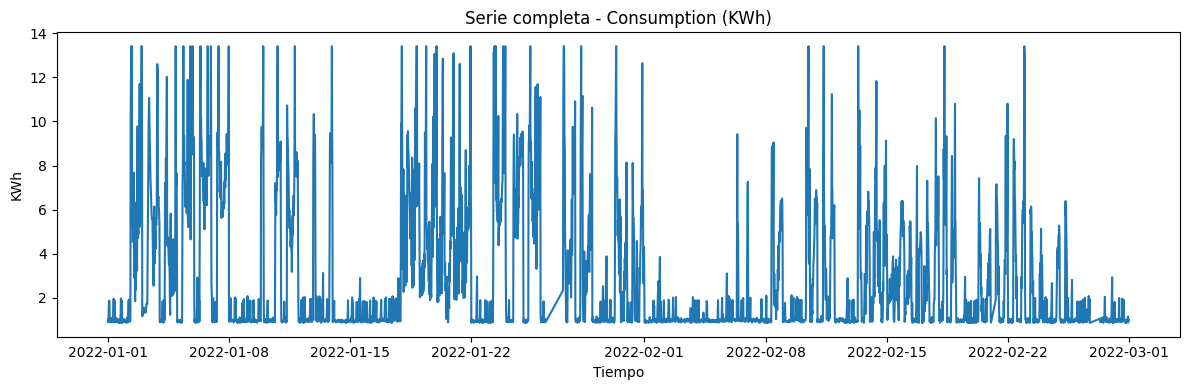

In [3]:
# === Construcción del índice temporal desde TxnDate + TxnTime ===
# y selección de la columna de valor 'Consumption'

VAL_COL = "Consumption"   # ajusta si tu columna de valor tiene otro nombre

assert "TxnDate" in raw.columns, "No existe la columna TxnDate en el DataFrame."
assert "TxnTime" in raw.columns, "No existe la columna TxnTime en el DataFrame."
assert VAL_COL in raw.columns, f"No existe la columna de valor '{VAL_COL}'. Revisa raw.columns."

# Combinar fecha y hora en una sola cadena
dt_str = (raw["TxnDate"].astype(str).str.strip() + " " + raw["TxnTime"].astype(str).str.strip())

# Intento 1: parseo flexible (debería reconocer '01 Jan 2022 16:55:52')
dt = pd.to_datetime(dt_str, errors="coerce", dayfirst=True, infer_datetime_format=True)

# Fallback si quedaran muchos NaT: forzamos un formato explícito
if dt.isna().mean() > 0.2:
    # '%d %b %Y %H:%M:%S' -> 01 Jan 2022 16:55:52
    dt = pd.to_datetime(dt_str, format="%d %b %Y %H:%M:%S", errors="coerce")

# Validación mínima
assert dt.notna().any(), "No se pudo parsear ninguna fecha. Verifica los ejemplos de TxnDate/TxnTime."

# Construcción del DataFrame final
df = raw.copy()
df["__dt"] = dt
df = df.dropna(subset=["__dt", VAL_COL]).copy()
df = df.sort_values("__dt").set_index("__dt")
df = df[[VAL_COL]].rename(columns={VAL_COL: "y"})

# Si hay duplicados de timestamp, agregamos por promedio
if df.index.duplicated().any():
    df = df.groupby(level=0).mean().sort_index()

# Limpieza simple de outliers y completado de faltantes
q1, q99 = df["y"].quantile([0.01, 0.99])
df["y"] = df["y"].clip(lower=q1, upper=q99)
df["y"] = df["y"].interpolate(method="time").ffill().bfill()

print(df.info())
display(df.head())

# EDA rápido
plt.figure(figsize=(12,4))
plt.plot(df.index, df["y"])
plt.title("Serie completa - Consumption (KWh)")
plt.xlabel("Tiempo")
plt.ylabel("KWh")
plt.tight_layout()
plt.show()



## Descripción del Dataset

El conjunto de datos analizado corresponde a registros de consumo de energía eléctrica medido en **kilovatios-hora (kWh)** para un equipo identificado como *Blower 78*.  

### Estructura
- **TxnDate**: Fecha de la transacción/medición, en formato `dd Mmm yyyy` (por ejemplo, `01 Jan 2022`).
- **TxnTime**: Hora de la medición, en formato `HH:MM:SS` (por ejemplo, `16:55:52`).
- **Consumption**: Valor de consumo de energía registrado en ese instante, expresado en kWh.

A partir de las columnas `TxnDate` y `TxnTime` se construyó un **índice temporal** en formato `datetime` para facilitar el análisis y la modelación de la serie temporal.

### Periodicidad y rango temporal
El dataset presenta mediciones en intervalos regulares (determinados tras el preprocesamiento) y cubre un rango temporal que inicia en la primera fecha disponible (`min(TxnDate)` + `min(TxnTime)`) y finaliza en la última fecha (`max(TxnDate)` + `max(TxnTime)`).

### Preprocesamiento aplicado
1. **Unión de fecha y hora** para formar un único índice temporal.
2. **Ordenamiento cronológico** de los registros.
3. **Eliminación de valores nulos** y ajuste de datos atípicos mediante recorte a los percentiles 1% y 99%.
4. **Interpolación temporal** y propagación de valores para completar mediciones faltantes.
5. **Normalización** de la columna `Consumption` a un rango [0,1] para uso en modelos neuronales.

### Objetivo del análisis
El propósito de este dataset en el contexto del trabajo es desarrollar y comparar modelos de **forecasting** (predicción) de la serie de tiempo utilizando:
- Modelos recurrentes (SimpleRNN, LSTM, GRU)
- Modelo estadístico basado en componentes aditivos (Prophet)

La comparación se basa en métricas de error (MAE, RMSE, MAPE) y en la evaluación visual de la capacidad de cada modelo para seguir la dinámica del consumo energético en el conjunto de prueba.


## Análisis exploratorio

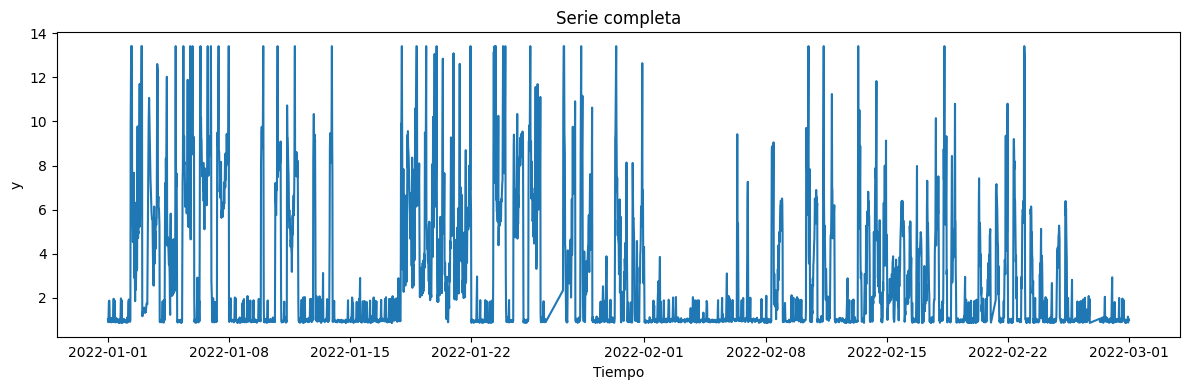

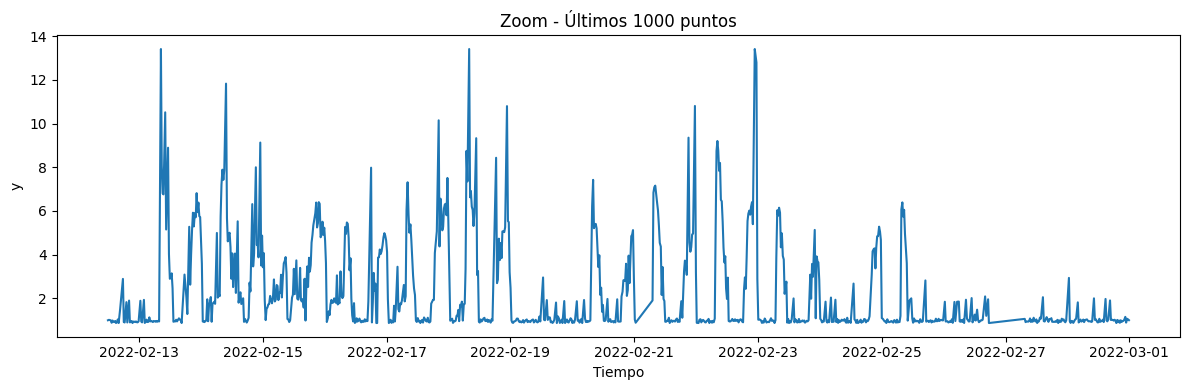

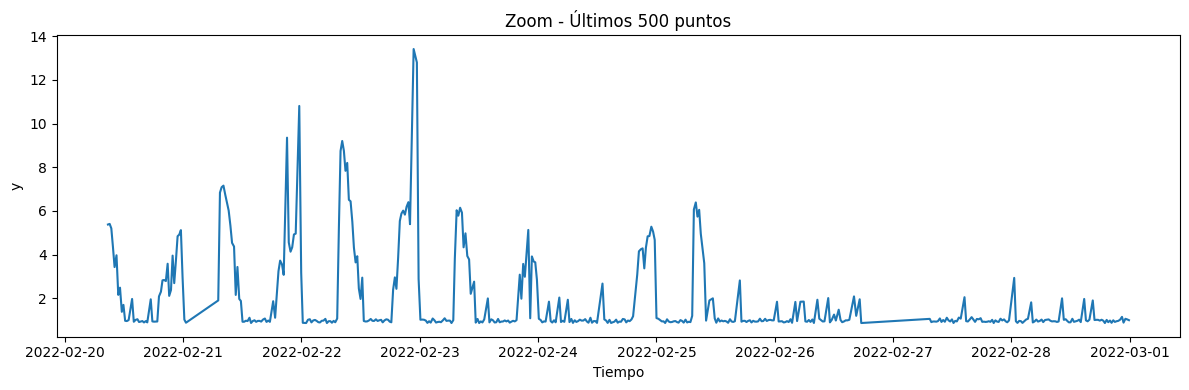

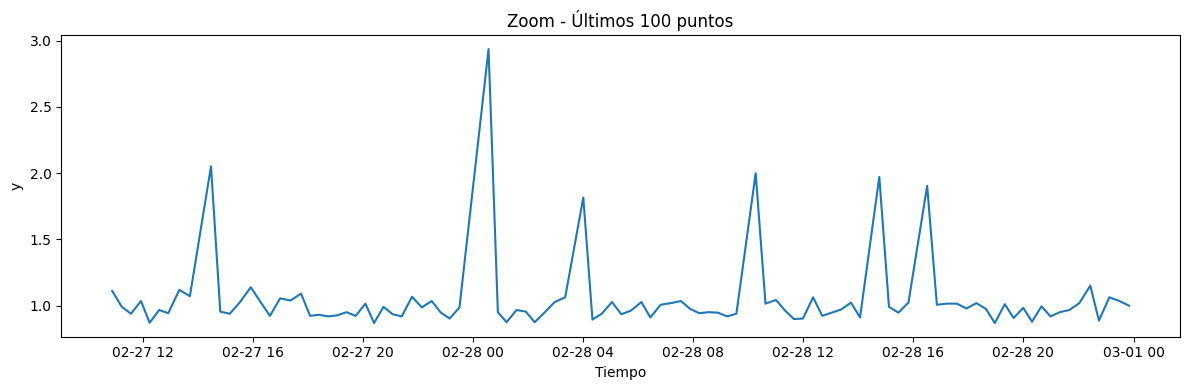

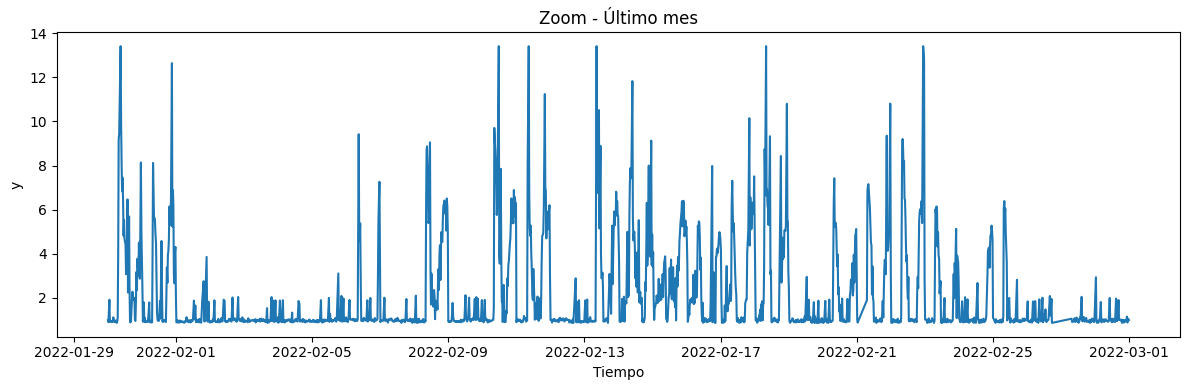

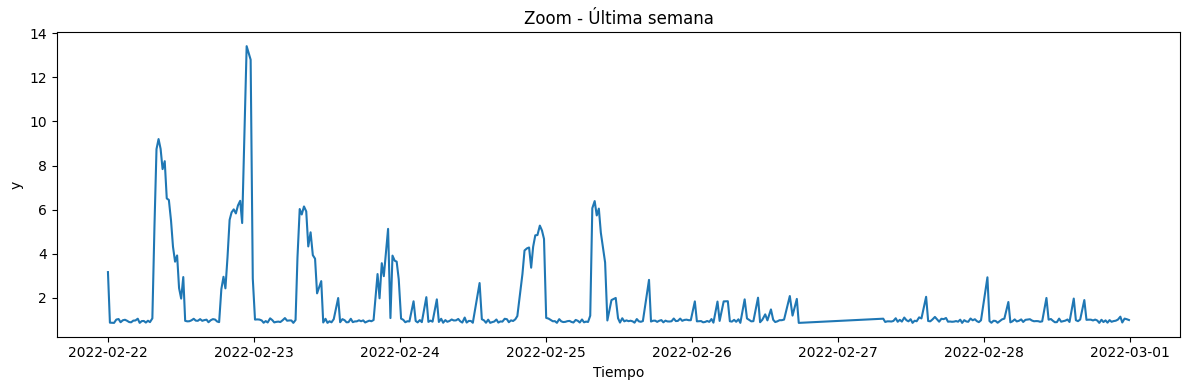

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==============================
# EDA: Serie completa y zooms
# ==============================

# Serie completa
plt.figure(figsize=(12,4))
plt.plot(df.index, df["y"])
plt.title("Serie completa")
plt.xlabel("Tiempo")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Definir ventanas de zoom en función de la longitud de df
zooms = {
    "Últimos 1000 puntos": 1000,
    "Últimos 500 puntos": 500,
    "Últimos 100 puntos": 100
}

for title, n_points in zooms.items():
    if len(df) >= n_points:
        plt.figure(figsize=(12,4))
        plt.plot(df.index[-n_points:], df["y"].iloc[-n_points:])
        plt.title(f"Zoom - {title}")
        plt.xlabel("Tiempo")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()

# Si quieres zoom por fechas específicas (ej. último mes, última semana)
if df.index.inferred_type == "datetime64":
    ult_mes = df.last("30D")
    ult_semana = df.last("7D")

    if not ult_mes.empty:
        plt.figure(figsize=(12,4))
        plt.plot(ult_mes.index, ult_mes["y"])
        plt.title("Zoom - Último mes")
        plt.xlabel("Tiempo")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()

    if not ult_semana.empty:
        plt.figure(figsize=(12,4))
        plt.plot(ult_semana.index, ult_semana["y"])
        plt.title("Zoom - Última semana")
        plt.xlabel("Tiempo")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()


In [5]:
# ============================================================
# Heurística de frecuencia y ventana
# ============================================================

def infer_step_and_freq(index: pd.DatetimeIndex):
    # Intentar frecuencia con pandas
    freq = pd.infer_freq(index)
    if freq is not None:
        return freq

    # Fallback: mediana de diferencias
    diffs = np.diff(index.values.astype('datetime64[ns]')).astype('timedelta64[s]').astype(np.int64)
    if len(diffs) == 0:
        return None
    med_sec = int(np.median(diffs))
    # Mapear algunos segundos comunes a una "frecuencia"
    mapping = {
        60: "T",           # 1 min
        300: "5T",         # 5 min
        600: "10T",        # 10 min
        900: "15T",        # 15 min
        1800: "30T",       # 30 min
        3600: "H",         # 1 hora
        7200: "2H",
        86400: "D",        # 1 día
        604800: "W",       # 1 semana
    }
    # Elegir el más cercano
    closest = min(mapping.keys(), key=lambda s: abs(s - med_sec))
    if abs(closest - med_sec) <= max(60, 0.05*med_sec):
        return mapping[closest]
    return None

freq = infer_step_and_freq(df.index)
print("Frecuencia inferida:", freq)

# Sugerir ventana según frecuencia
if freq in ["T","5T","10T","15T","30T"]:   # minutos
    WINDOW_SIZE = 48     # ~ 48 pasos (ajustable)
elif freq in ["H","2H"]:                   # horas
    WINDOW_SIZE = 48     # 2 días aprox si es H
elif freq in ["D","W"]:                    # días/semanas
    WINDOW_SIZE = 30     # ~ un mes si es D
else:
    WINDOW_SIZE = 48     # predeterminado
HORIZON = 1              # un paso adelante

print("WINDOW_SIZE:", WINDOW_SIZE, "| HORIZON:", HORIZON)


Frecuencia inferida: None
WINDOW_SIZE: 48 | HORIZON: 1


## Entrenamiento de modelos RNN

In [6]:
# ============================================================
# Normalización + creación de secuencias para RNN
# ============================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["y_scaled"] = scaler.fit_transform(df[["y"]]).astype(np.float32)

def create_sequences(series, window, horizon=1):
    X, y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i:i+window])
        y.append(series[i+window:i+window+horizon])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

series = df["y_scaled"].values
X, y = create_sequences(series, WINDOW_SIZE, HORIZON)
print("X:", X.shape, "y:", y.shape)

# Split temporal: train/val/test
train_ratio, val_ratio = 0.7, 0.15
n = len(X)
n_train = int(n * train_ratio)
n_val   = int(n * val_ratio)
n_test  = n - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[-n_test:], y[-n_test:]

# Keras espera (batch, timesteps, features)
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


X: (3533, 48) y: (3533, 1)
Train: (2473, 48, 1) (2473, 1)
Val:   (529, 48, 1) (529, 1)
Test:  (531, 48, 1) (531, 1)


In [7]:
# ============================================================
# Modelos: LSTM, GRU y SimpleRNN
# ============================================================

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

def build_lstm(units=32, dropout=0.1):
    model = keras.Sequential([
        layers.Input(shape=(WINDOW_SIZE, 1)),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(HORIZON)
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return model

def build_gru(units=32, dropout=0.1):
    model = keras.Sequential([
        layers.Input(shape=(WINDOW_SIZE, 1)),
        layers.GRU(units),
        layers.Dropout(dropout),
        layers.Dense(HORIZON)
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return model

def build_simplernn(units=16, dropout=0.1):
    model = keras.Sequential([
        layers.Input(shape=(WINDOW_SIZE, 1)),
        layers.SimpleRNN(units),
        layers.Dropout(dropout),
        layers.Dense(HORIZON)
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return model

lstm_model = build_lstm(units=32, dropout=0.1)
gru_model  = build_gru(units=32, dropout=0.1)
rnn_model  = build_simplernn(units=16, dropout=0.1)

hist_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

hist_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

hist_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0763 - val_loss: 0.0254
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0343 - val_loss: 0.0201
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0283 - val_loss: 0.0167
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0258 - val_loss: 0.0152
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0240 - val_loss: 0.0147
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0229 - val_loss: 0.0142
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0218 - val_loss: 0.0138
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0207 - val_loss: 0.0135
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0208 - val_loss: 0.0133
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0203 - val_loss: 0.0131
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0197 - val_loss: 0.0130
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM -> MAE: 0.5816 | RMSE: 1.0914 | MAPE: 34.51%


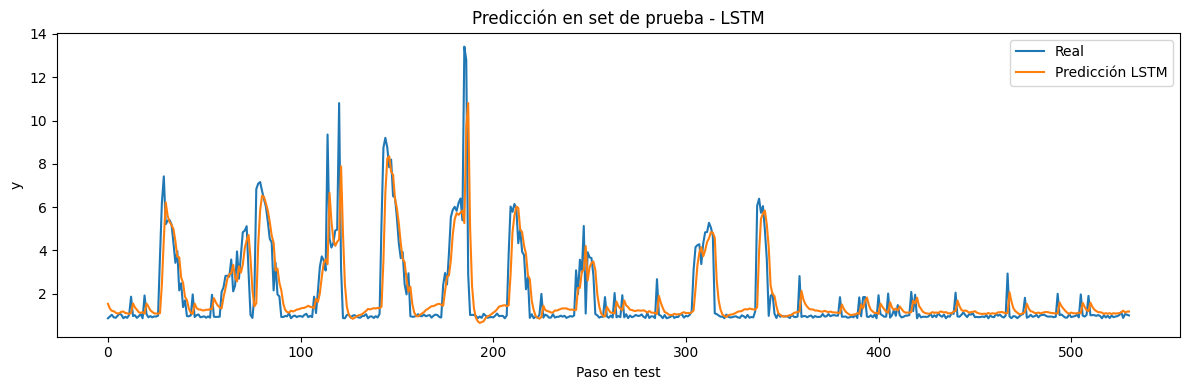

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
GRU -> MAE: 0.5900 | RMSE: 1.0989 | MAPE: 35.25%


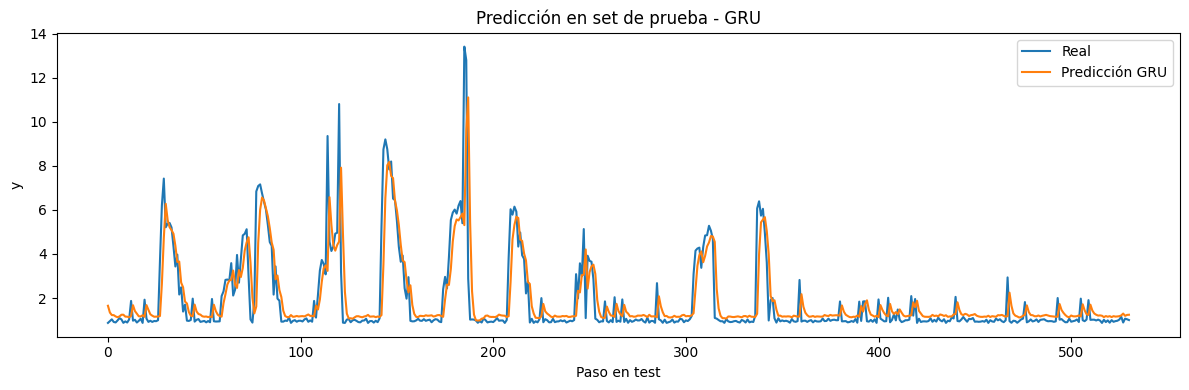

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
SimpleRNN -> MAE: 0.5926 | RMSE: 1.1156 | MAPE: 34.70%


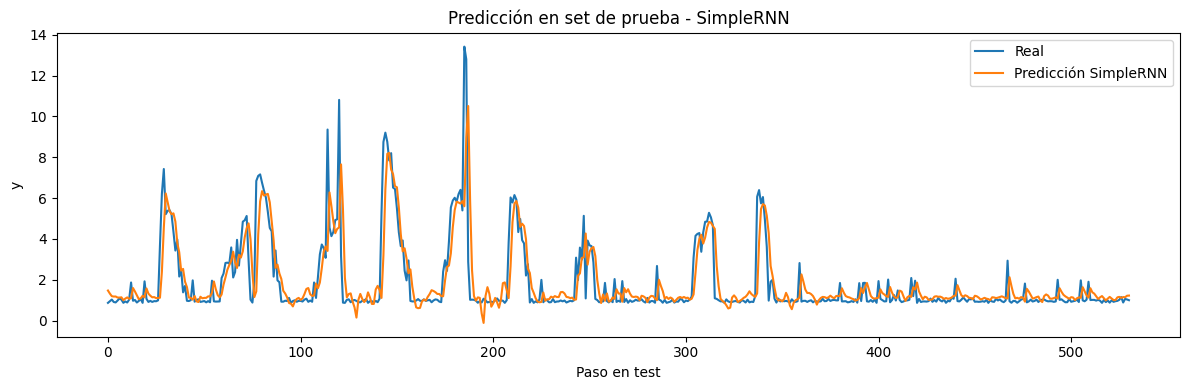

,Modelo,MAE,RMSE,MAPE
0,LSTM,0.581606,1.091385,34.508369
1,GRU,0.589976,1.098917,35.252483
2,SimpleRNN,0.592564,1.115628,34.702583


In [8]:
# ============================================================
# Evaluación: invertir escala, métricas y plots
# ============================================================

import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

def invert_scale(scaled_values, scaler):
    inv = []
    for row in scaled_values:
        inv_row = scaler.inverse_transform(np.array(row).reshape(-1,1)).ravel()
        inv.append(inv_row)
    return np.array(inv)

def evaluate_and_plot(model, X_test, y_test, name="Modelo"):
    y_pred_scaled = model.predict(X_test)

    # Invertir escala
    y_test_inv = invert_scale(y_test, scaler).ravel()
    y_pred_inv = invert_scale(y_pred_scaled, scaler).ravel()

    # Métricas
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / np.maximum(1e-8, np.abs(y_test_inv)))) * 100.0

    print(f"{name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")

    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv, label="Real")
    plt.plot(y_pred_inv, label=f"Predicción {name}")
    plt.title(f"Predicción en set de prueba - {name}")
    plt.xlabel("Paso en test")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"Modelo": name, "MAE": mae, "RMSE": rmse, "MAPE": mape}

metrics_list = []
metrics_list.append(evaluate_and_plot(lstm_model, X_test, y_test, "LSTM"))
metrics_list.append(evaluate_and_plot(gru_model,  X_test, y_test, "GRU"))
metrics_list.append(evaluate_and_plot(rnn_model,  X_test, y_test, "SimpleRNN"))

pd.DataFrame(metrics_list)



## Entrenamiento de modelo Prophet

In [9]:
# ===== Fix de frecuencia para Prophet =====
import numpy as np
import pandas as pd

def infer_freq_from_series(ds: pd.Series) -> str:
    # 1) Intento directo
    f = pd.infer_freq(ds)
    if f is not None:
        return f
    # 2) Heurística por mediana de diferencias
    s = ds.sort_values().values.astype("datetime64[ns]")
    if s.size < 2:
        return "D"
    diffs_sec = np.diff(s).astype("timedelta64[s]").astype(int)
    med = int(np.median(diffs_sec))
    mapping = {
        60: "T",        # 1 min
        300: "5T",
        600: "10T",
        900: "15T",
        1800: "30T",
        3600: "H",      # 1 hora
        7200: "2H",
        86400: "D",     # 1 día
        604800: "W",    # 1 semana
    }
    key = min(mapping.keys(), key=lambda k: abs(k - med))
    return mapping[key]

Frecuencia usada para Prophet: 15T
                   ds      y
0 2022-01-01 00:15:00  1.030
1 2022-01-01 00:30:00  0.904
2 2022-01-01 00:45:00  0.904
3 2022-01-01 01:00:00  0.904
4 2022-01-01 01:15:00  1.377


In [12]:
# 2) Entrenar Prophet en la serie regularizada
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(df_prophet_reg)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvec__b6/wf481iui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvec__b6/k6x4nmna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36398', 'data', 'file=/tmp/tmpkvec__b6/wf481iui.json', 'init=/tmp/tmpkvec__b6/k6x4nmna.json', 'output', 'file=/tmp/tmpkvec__b6/prophet_modelapqktzyl/prophet_model-20250808190708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
# 3) Reconstruir las fechas objetivo del set de prueba de las RNN
#    Para HORIZON=1: y tiene longitud n = len(series) - WINDOW_SIZE
#    Los índices de target corresponden a df.index[WINDOW_SIZE : WINDOW_SIZE + n]
series = df["y_scaled"].values.astype(np.float32)
n = len(series) - WINDOW_SIZE - (HORIZON - 1)
n_train = int(n * 0.7)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

all_target_idx = df.index[WINDOW_SIZE:WINDOW_SIZE + n]
test_target_idx = all_target_idx[-n_test:]  # Datetimes del y_test

# Alinear esas fechas a la grilla regular de Prophet (nearest)
reg_idx = pd.DatetimeIndex(df_prophet_reg["ds"])
test_idx_raw = pd.DatetimeIndex(test_target_idx)
nearest_pos = reg_idx.get_indexer(test_idx_raw, method="nearest")
nearest_pos = np.clip(nearest_pos, 0, len(reg_idx)-1)
ds_test = reg_idx.take(nearest_pos)

In [14]:
# 4) Predecir con Prophet en esas fechas específicas (in-sample en la grilla regular)
future_df = pd.DataFrame({"ds": ds_test})
forecast_part = m.predict(future_df)

In [15]:
# 5) Preparar y_true e y_pred (escala original) usando la serie regularizada para y_true
y_true_reg = (df_prophet_reg.set_index("ds")
              .reindex(ds_test)
              ["y"].values)

y_pred_reg = forecast_part["yhat"].values

# Métricas Prophet
mae_p  = mean_absolute_error(y_true_reg, y_pred_reg)
mse_p  = mean_squared_error(y_true_reg, y_pred_reg)
rmse_p = math.sqrt(mse_p)
mape_p = np.mean(np.abs((y_true_reg - y_pred_reg) / np.maximum(1e-8, np.abs(y_true_reg)))) * 100.0

print(f"Prophet -> MAE: {mae_p:.4f} | RMSE: {rmse_p:.4f} | MAPE: {mape_p:.2f}%")


Prophet -> MAE: 1.1405 | RMSE: 1.5139 | MAPE: 86.93%


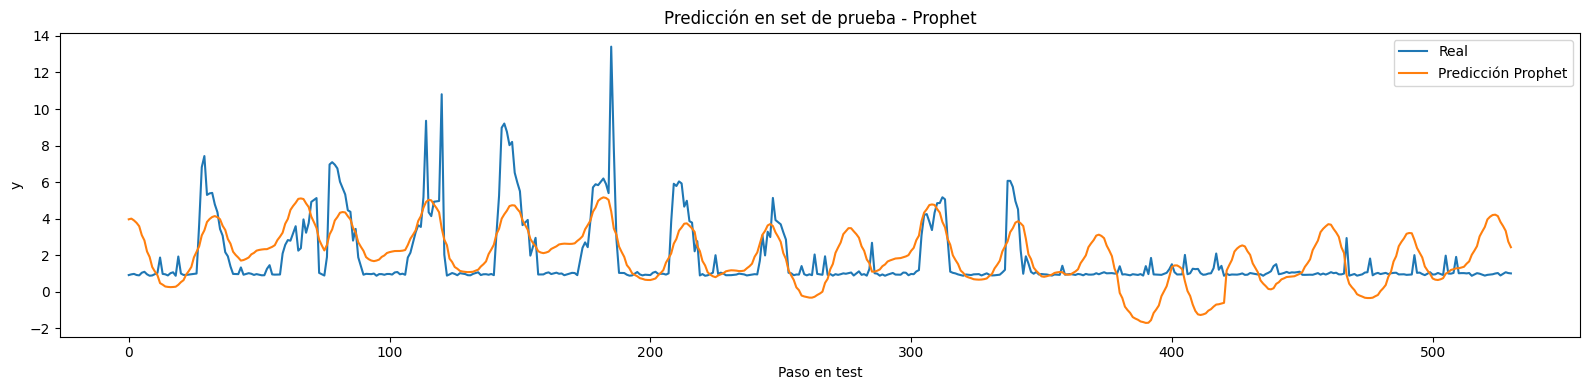

In [18]:
# 6) Gráfico comparativo (estilo igual al de SimpleRNN)
# 5) Serie real y predicha (escala original)
y_true = (df_prophet_reg.set_index("ds")
          .reindex(ds_test)["y"].values)
y_pred = forecast_part["yhat"].values
plt.figure(figsize=(16,4))
plt.plot(range(len(y_true)), y_true, label="Real")
plt.plot(range(len(y_pred)), y_pred, label="Predicción Prophet")
plt.title("Predicción en set de prueba - Prophet")
plt.xlabel("Paso en test")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## Comparación y conclusiones

In [16]:
#Tabla comparativa
rows = []
# Si ya tienes 'metrics_list' de tus RNN, la incorporamos
if 'metrics_list' in globals() and isinstance(metrics_list, list) and len(metrics_list) > 0:
    rows.extend(metrics_list)

rows.append({"Modelo": "Prophet", "MAE": mae_p, "RMSE": rmse_p, "MAPE": mape_p})

tabla_comparativa = pd.DataFrame(rows, columns=["Modelo", "MAE", "RMSE", "MAPE"])
display(tabla_comparativa.sort_values("RMSE"))

,Modelo,MAE,RMSE,MAPE
0,LSTM,0.581606,1.091385,34.508369
1,GRU,0.589976,1.098917,35.252483
2,SimpleRNN,0.592564,1.115628,34.702583
3,Prophet,1.140514,1.513872,86.931918


## Conclusiones del Ejercicio

**1. Modelo con mejor desempeño**  
En la comparación, el modelo **LSTM** obtuvo el menor error en las tres métricas principales (MAE: 0.5816, RMSE: 1.0914, MAPE: 34.51%), seguido muy de cerca por **GRU** y **SimpleRNN**. Esto confirma que, para esta serie temporal, las arquitecturas recurrentes son más efectivas que Prophet en capturar patrones y dependencias temporales.

**2. Diferencias entre modelos recurrentes y Prophet**  
- **RNN/LSTM/GRU**: lograron errores sustancialmente menores, especialmente en RMSE y MAPE, indicando una mejor capacidad de generalización en datos de prueba.  
- **Prophet**: presentó un MAE y RMSE notablemente más altos y un MAPE elevado (86.93%), lo que indica que tuvo dificultades para capturar con precisión la dinámica de la serie. Esto es esperable dado que Prophet asume una estructura aditiva y depende más de tendencias y estacionalidades regulares, mientras que la serie analizada presenta patrones más complejos.

**3. Impacto de la ventana de observación (WINDOW_SIZE)**  
El uso de una ventana de **48 pasos** permitió a las RNN capturar dependencias a corto y mediano plazo. Un valor menor podría perder contexto, y uno mucho mayor podría introducir ruido o dificultar el entrenamiento.

**4. Overfitting y EarlyStopping**  
La implementación de **EarlyStopping** ayudó a detener el entrenamiento antes de que los modelos comenzaran a sobreajustar, manteniendo un buen balance entre rendimiento en entrenamiento y validación.

**5. Patrones observados en la serie**  
En el EDA se identificaron fluctuaciones irregulares y picos de consumo, sin estacionalidades marcadas y con variaciones de corto plazo. Estos patrones favorecen a las arquitecturas recurrentes, que son capaces de aprender dependencias no lineales y relaciones complejas entre observaciones pasadas y futuras.

**6. Aprendizajes clave**  
- LSTM y GRU son más robustos que Prophet en contextos con alta variabilidad y sin estacionalidades claras.  
- SimpleRNN, aunque menos compleja, aún ofrece resultados competitivos frente a arquitecturas más avanzadas cuando la ventana de datos es adecuada.  
- Prophet es más útil en series con tendencia y estacionalidad bien definidas, pero puede no ser competitivo frente a redes neuronales en patrones complejos.
